### 1. Problem Statement
a deep 3D-CNN is proposed to predict the anisotropic effective material properties for RVE with random inclusions.

ref. Three-dimensional convolutional neural network (3D-CNN) for heterogeneous material homogenization

### 2. Data extraction
### 3. Data scaling
### 4. Model tuning
### 5. Model serving (if applicable)

In [1]:
import numpy as np
import scipy.io
import keras
import random
import time
import gc
import os
import matplotlib.pyplot as plt
from random import shuffle
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.optimizers import RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam, SGD, TFOptimizer
from keras.layers import Conv3D, MaxPooling3D, TimeDistributed, Flatten, LSTM, Reshape, BatchNormalization, Activation, UpSampling1D, ZeroPadding1D, PReLU
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model

In [2]:
# set environment
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # CPU:-1; GPU0: 1; GPU1: 0;

### 2. Data Extraction

In [3]:
########### Load dataset {(x,y)} from multiple files #############
dataDir = "../data/"
X_data1 = scipy.io.loadmat(dataDir + 'phase_2nd_0_199.mat')['phase']
X_data2 = scipy.io.loadmat(dataDir + 'phase_2nd_200_399.mat')['phase']
X_data3 = scipy.io.loadmat(dataDir + 'phase_3rd_0_199.mat')['phase']
X_data4 = scipy.io.loadmat(dataDir + 'phase_3rd_200_399.mat')['phase']
X_data5 = scipy.io.loadmat(dataDir + 'phase_3rd_400_599.mat')['phase']
X_data6 = scipy.io.loadmat(dataDir + 'phase_3rd_600_799.mat')['phase']
X_data7 = scipy.io.loadmat(dataDir + 'phase_3rd_800_999.mat')['phase']
X_data8 = scipy.io.loadmat(dataDir + 'phase_3rd_1000_1199.mat')['phase']
# X_data9 = scipy.io.loadmat(dataDir + 'phase_3rd_1200_1399.mat')['phase']
# X_data10 = scipy.io.loadmat(dataDir + 'phase_3rd_1400_1599.mat')['phase']

In [4]:
# method 2: datatype conversions
X_data1 = X_data1.astype('bool')
X_data2 = X_data2.astype('bool')
X_data3 = X_data3.astype('bool')
X_data4 = X_data4.astype('bool')
X_data5 = X_data5.astype('bool')
X_data6 = X_data6.astype('bool')
X_data7 = X_data7.astype('bool')
X_data8 = X_data8.astype('bool')
# X_data9 = X_data9.astype('bool')
# X_data10 = X_data10.astype('bool')

In [5]:
X_data = np.concatenate([X_data1, X_data2, X_data3, X_data4, X_data5,
                         X_data6, X_data7, X_data8])
X_data = np.reshape(X_data, [X_data.shape[0], X_data.shape[1], X_data.shape[2], X_data.shape[3], 1])

In [6]:
# method 1: delete unused data
del [[X_data1, X_data2, X_data3, X_data4, X_data5, X_data6, X_data7, X_data8]]
gc.collect()

0

In [7]:
y_data1 = scipy.io.loadmat(dataDir + 'label_2nd.mat')['label']
y_data2 = scipy.io.loadmat(dataDir + 'label_3rd.mat')['label']
y_data = np.concatenate([y_data1, y_data2[0:1200]])

In [8]:
del [[y_data1, y_data2]]
gc.collect()

0

### 3. Data Scaling

In [9]:
########### Scale data through MinMaxScaler ############
########### E, v (mu) are scaled separately ############
########### E_data -> E_data_map            ############
E_data = y_data[:, 0:6]
E_data_flatten = np.reshape(E_data, [E_data.shape[0], E_data.shape[1]])
scaler_E = MinMaxScaler(feature_range=(0, 1))
scaler_E.fit(E_data_flatten)
E_data_flatten_map = scaler_E.transform(E_data_flatten)
E_data_map = np.reshape(E_data_flatten_map, [E_data.shape[0], E_data.shape[1]])

v_data = y_data[:, 6:]
v_data_flatten = np.reshape(v_data, [v_data.shape[0], v_data.shape[1]])
scaler_v = MinMaxScaler(feature_range=(0, 1))
scaler_v.fit(v_data_flatten)
v_data_flatten_map = scaler_v.transform(v_data_flatten)
v_data_map = np.reshape(v_data_flatten_map, [v_data.shape[0], v_data.shape[1]])
y_data_map = np.concatenate([E_data_map, v_data_map], axis=1)

In [10]:
# Input shape, output shape
input_shape = X_data.shape[1:]
num_classes = y_data.shape[-1]  # number of output features
batch_size = 25
print(input_shape, num_classes)

(101, 101, 101, 1) 12


### 4. Model Tuning
- Model 4: Conv(16, 5) + Conv(16,5) + Conv(32, 5) + global average pooling + FC(64*32)

In [14]:
adam = Adam(learning_rate=0.0001)
model = Sequential()
model.add(Conv3D(16, 5, strides=1, padding='valid', use_bias=True, input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(16, 5, strides=1, padding='valid', use_bias=True))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(32, 5, strides=1, padding='valid', use_bias=True))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(keras.layers.GlobalAveragePooling3D ())
model.add(Flatten())
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(num_classes))

model.summary()
model.compile(loss='mean_squared_error',
              optimizer=adam,                # RMSprop(), Adagrad, Nadam, Adagrad, Adadelta, Adam, Adamax,
              metrics=['mse', 'mape'])
best_loss = 100
train_loss = []
val_loss = []
history = []

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 97, 97, 97, 16)    2016      
                                                                 
 activation_9 (Activation)   (None, 97, 97, 97, 16)    0         
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 48, 48, 48, 16)   0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 44, 44, 44, 16)    32016     
                                                                 
 activation_10 (Activation)  (None, 44, 44, 44, 16)    0         
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 22, 22, 22, 16)   0         
 g3D)                                                 

In [ ]:
#with tf.device('/device:CPU:0'):
with tf.device('/device:GPU:0'):

    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.compat.v1.Session(config=config)

    start = time.time()

    # Load pre-trained model if exists
   # model = load_model("./saved_models/my_best_model_CNN_new.h5")

    ######### Randomly shuffle the data set  ##########
    ######### split them into train/val/test ##########
    random.seed(4)
    Ind = list(range(len(X_data)))
    shuffle(Ind)
    ratio_split = 0.7
    
    epochs = 1000
    for e in range(epochs):
        print('epoch = ', e + 1)
        
        Ind_tr = Ind[0:round(ratio_split * len(Ind))]
        Ind_val = Ind[round(ratio_split * len(Ind)):round(0.85 * len(Ind))]
        Ind_test = Ind[round(0.85 * len(Ind)):]
    
        X_train = X_data[Ind_tr]
        y_train_map = y_data_map[Ind_tr]
        X_val = X_data[Ind_val]
        y_val_map = y_data_map[Ind_val]
        
        early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                          restore_best_weights=True)
        
        model.fit(X_train, y_train_map,
                  batch_size=batch_size,
                  # validation_split=0.2,
                  validation_data=(X_val, y_val_map),
                  callbacks=early_stopping_cb,
                  shuffle=True,
                  epochs=1)
        score0 = model.evaluate(X_train, y_train_map, batch_size=batch_size, verbose=0)
        score = model.evaluate(X_val, y_val_map, batch_size=batch_size, verbose=0)
        train_loss.append(score0[0])
        val_loss.append(score[0])
        
        if e > 500:
            keras.backend.set_value(adam.learning_rate, 0.00005)

        if val_loss[e] < best_loss:
            best_loss = val_loss[e]
            model.save("../saved_models/model4.h5")

    end = time.time()
    running_time = end - start
    print('Running Time: ', running_time, ' sec')


epoch =  1
45/45 [==============================] - 2154s 48s/step - loss: 0.2223 - mse: 0.2223 - mape: 43176.4453 - val_loss: 0.1136 - val_mse: 0.1136 - val_mape: 165.1566
epoch =  2
45/45 [==============================] - 2154s 48s/step - loss: 0.0975 - mse: 0.0975 - mape: 174446.8594 - val_loss: 0.0715 - val_mse: 0.0715 - val_mape: 129.1652
epoch =  3
45/45 [==============================] - 2162s 48s/step - loss: 0.0486 - mse: 0.0486 - mape: 75299.8125 - val_loss: 0.0168 - val_mse: 0.0168 - val_mape: 83.5447
epoch =  4
45/45 [==============================] - 2170s 48s/step - loss: 0.0096 - mse: 0.0096 - mape: 44307.0625 - val_loss: 0.0040 - val_mse: 0.0040 - val_mape: 43.3774
epoch =  5
45/45 [==============================] - 2171s 48s/step - loss: 0.0043 - mse: 0.0043 - mape: 42541.6016 - val_loss: 0.0026 - val_mse: 0.0026 - val_mape: 32.8538
epoch =  6
45/45 [==============================] - 2184s 49s/step - loss: 0.0032 - mse: 0.0032 - mape: 47432.7227 - val_loss: 0.0019 - v

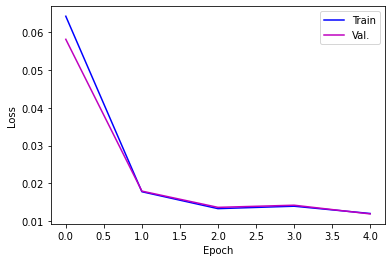

In [15]:
# Plot the history of loss
fig, ax = plt.subplots()
ax.plot(np.array(train_loss), 'b-', label='Train')
ax.plot(np.array(val_loss), 'm-', label='Val.')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()